In [1]:
import jax
import os
from sklearn import datasets
import scanpy as sc
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np
import scipy

import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from genot.models.model import GENOT
from genot.nets.nets import MLP_vector_field, MLP_marginal
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from sklearn import preprocessing as pp
import moscot as mt

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/py

In [2]:
adata_atac = mt.datasets.bone_marrow(rna=False)
adata_rna = mt.datasets.bone_marrow(rna=True)

In [3]:
adata_rna

AnnData object with n_obs × n_vars = 6224 × 2000
    obs: 'GEX_n_counts', 'GEX_n_genes', 'cell_type', 'batch'
    uns: 'cell_type_colors', 'neighbors'
    obsm: 'GEX_X_pca', 'X_umap', 'geneactivity_scvi'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
adata_atac

AnnData object with n_obs × n_vars = 6224 × 8000
    obs: 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'cell_type', 'batch'
    uns: 'cell_type_colors', 'neighbors'
    obsm: 'ATAC_lsi_full', 'ATAC_lsi_red', 'X_umap', 'geneactivity_scvi'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

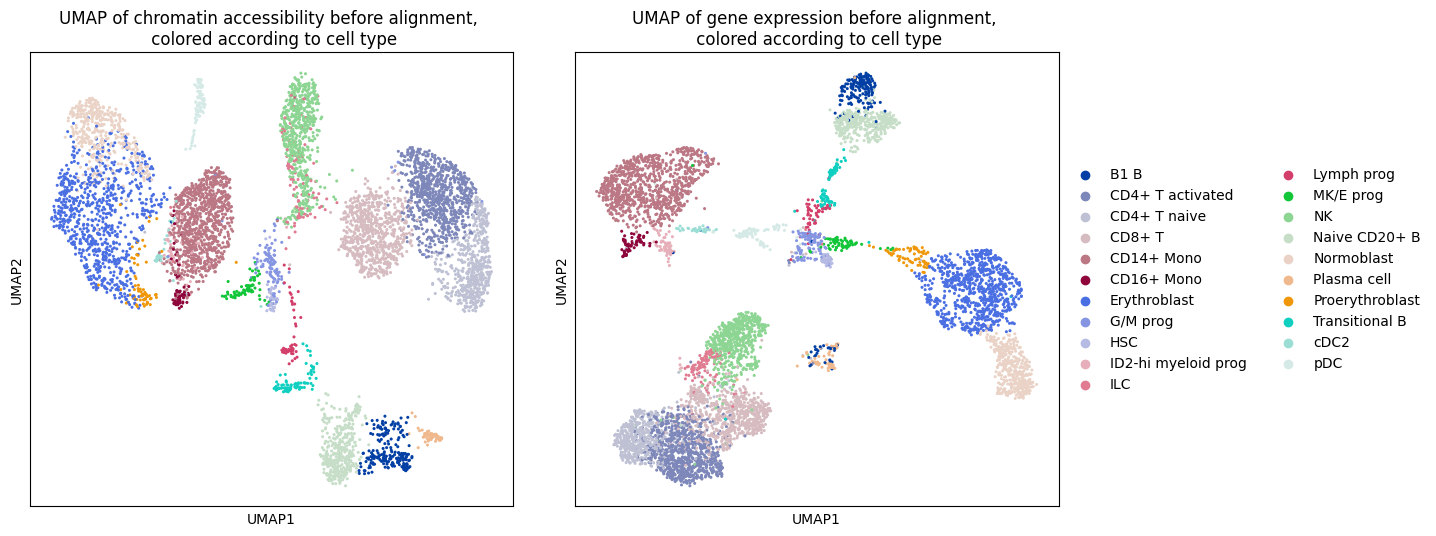

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_atac, color="cell_type", ax=ax1, show=False)
ax1.legend().remove()
ax1.set_title(
    "UMAP of chromatin accessibility before alignment, \n colored according to cell type"
)
sc.pl.umap(adata_rna, color="cell_type", ax=ax2, show=False)
ax2.set_title(
    "UMAP of gene expression before alignment, \n colored according to cell type"
)
plt.tight_layout(pad=3.0)
plt.show()

In [6]:
adata_source=adata_atac.copy()
adata_target=adata_rna.copy()

n_cells_source=len(adata_atac)

n_samples_train = int(n_cells_source * 0.6)
n_samples_test = n_cells_source - n_cells_source

inds_train = np.asarray(jax.random.choice(jax.random.PRNGKey(0), n_cells_source, (n_samples_train,), replace=False))
inds_test = list(set(list(range(n_cells_source))) - set(np.asarray(inds_train)))

source_train = adata_source.obsm["ATAC_lsi_red"][inds_train,:]
source_test = adata_source.obsm["ATAC_lsi_red"][inds_test,:]

target_train = adata_target.obsm["GEX_X_pca"][inds_train,:]
target_test = adata_target.obsm["GEX_X_pca"][inds_test,:]

adata_source_train = adata_source[inds_train,:]
adata_source_test = adata_source[inds_test,:]

adata_target_train = adata_target[inds_train,:]
adata_target_test = adata_target[inds_test,:]

## L2 cost

In [7]:
neural_net = MLP_vector_field(target_train.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)
linear_ot_solver = sinkhorn.Sinkhorn(
                momentum=acceleration.Momentum(value=1., start=25)
        )
solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=0.01, linear_ot_solver=linear_ot_solver)
#solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=0.01)


genot = GENOT(neural_net, 
              epsilon=None, 
              scale_cost="mean", 
              input_dim=source_train.shape[1], 
              output_dim=target_train.shape[1], 
              iterations=3_000, 
              ot_solver=solver, 
              k_noise_per_x=1, 
              fused_penalty = 0)

In [8]:
genot(source_train, target_train, 1024, 1024)

I0000 00:00:1734530325.205120 1646515 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3257 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 3g.20gb, pci bus id: 0000:c3:00.0, compute capability: 8.0
100%|██████████| 3000/3000 [1:19:58<00:00,  1.60s/it]


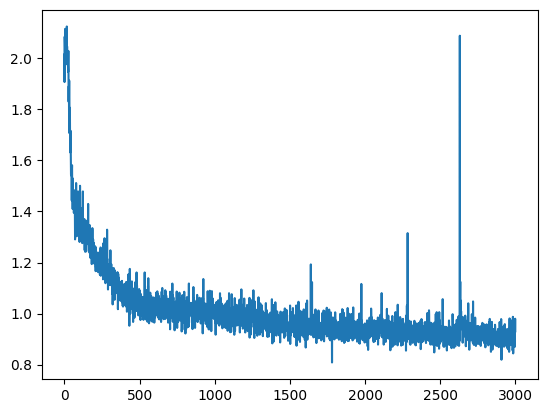

In [9]:
plt.plot(np.arange(len(genot.metrics["loss"])), genot.metrics["loss"])

In [10]:
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

In [11]:
res_train = [None] * 30
res_test = [None] * 30

for i in range(30):
    res_train[i] = genot.transport(source_train, seed=i)[0][0,...]
    res_test[i] = genot.transport(source_test, seed=i)[0][0,...]

In [12]:
cond_mean_train = jnp.mean(jnp.asarray(res_train), axis=0)
cond_mean_test = jnp.mean(jnp.asarray(res_test), axis=0)

In [13]:
foscttm(res_train[0], target_train)

0.5282

In [14]:
foscttm(res_test[0], target_test)

0.5253

In [15]:
foscttm(cond_mean_train, target_train)

0.5245

In [16]:
foscttm(cond_mean_test, target_test)

0.5241

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


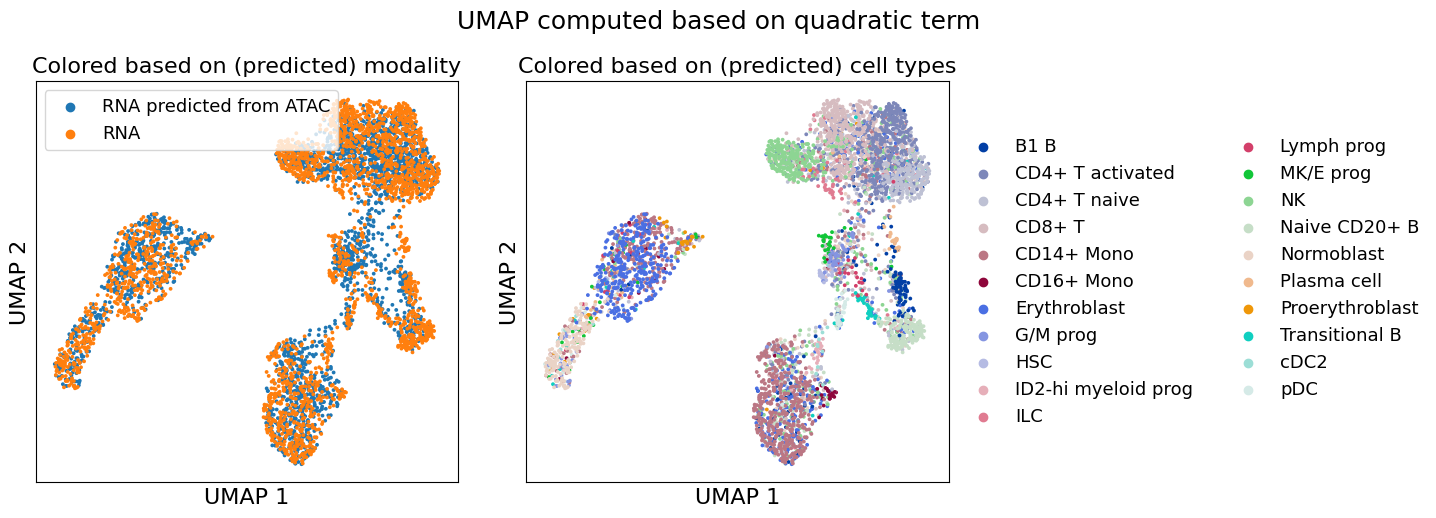

In [17]:
adata_one_sample = sc.concat(
    [adata_source_test, adata_target_test],
    join="outer",
    label="batch",
    keys=["RNA predicted from ATAC", "RNA"],
)
adata_one_sample.obsm["X_translated_0"] = np.concatenate(
    (res_test[0], target_test), axis=0
)
sc.pp.neighbors(adata_one_sample, use_rep="X_translated_0")
sc.tl.umap(adata_one_sample)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("UMAP computed based on quadratic term", size=18, y=0.9)
sc.pl.umap(adata_one_sample, color=["batch"], ax=ax1, show=False, size=30, legend_fontsize=10)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality", fontsize=16)
ax1.set_xlabel('UMAP 1', fontsize=16)
ax1.set_ylabel('UMAP 2', fontsize=16)
sc.pl.umap(adata_one_sample, color=["cell_type"], ax=ax2, show=False, size=30, legend_fontsize=13)
ax2.set_title("Colored based on (predicted) cell types", fontsize=16)
ax2.set_xlabel('UMAP 1', fontsize=16)
ax2.set_ylabel('UMAP 2', fontsize=16)
ax1.legend(fontsize=13)
plt.tight_layout(pad=3.0)
plt.show()

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


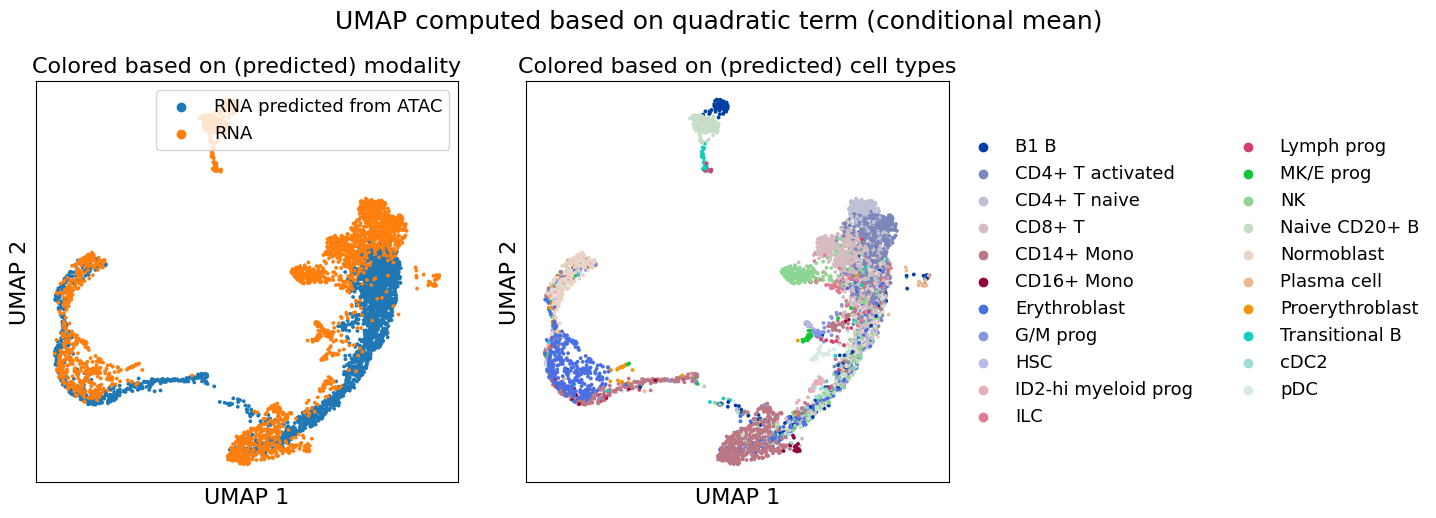

In [18]:
adata_cond_mean = sc.concat(
    [adata_source_test, adata_target_test],
    join="outer",
    label="batch",
    keys=["RNA predicted from ATAC", "RNA"],
)
adata_cond_mean.obsm["X_translated_0"] = np.concatenate(
    (cond_mean_test, target_test), axis=0
)
sc.pp.neighbors(adata_cond_mean, use_rep="X_translated_0")
sc.tl.umap(adata_cond_mean)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("UMAP computed based on quadratic term (conditional mean)", size=18, y=0.9)

sc.pl.umap(adata_cond_mean, color=["batch"], ax=ax1, show=False, size=30, legend_fontsize=10)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality", fontsize=16)
ax1.set_xlabel('UMAP 1', fontsize=16)
ax1.set_ylabel('UMAP 2', fontsize=16)
sc.pl.umap(adata_cond_mean, color=["cell_type"], ax=ax2, show=False, size=30, legend_fontsize=13)
ax2.set_title("Colored based on (predicted) cell types", fontsize=16)
ax2.set_xlabel('UMAP 1', fontsize=16)
ax2.set_ylabel('UMAP 2', fontsize=16)
ax1.legend(fontsize=13)
plt.tight_layout(pad=3.0)
plt.show()

## Geodesic cost

In [19]:
neural_net = MLP_vector_field(target_train.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)
linear_ot_solver = sinkhorn.Sinkhorn(
                momentum=acceleration.Momentum(value=1., start=25)
        )
solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=0.01, linear_ot_solver=linear_ot_solver)

genot = GENOT(neural_net, 
              cost_fn="graph", 
              graph_kwargs={"k_neighbors": 1025}, 
              epsilon=None, 
              scale_cost="mean", 
              input_dim=source_train.shape[1], 
              output_dim=target_train.shape[1], 
              iterations=3_000, 
              ot_solver=solver, 
              k_noise_per_x=1, 
              fused_penalty=0)

In [20]:
genot(source_train, target_train, 1024, 1024)

100%|██████████| 3000/3000 [35:13<00:00,  1.42it/s] 


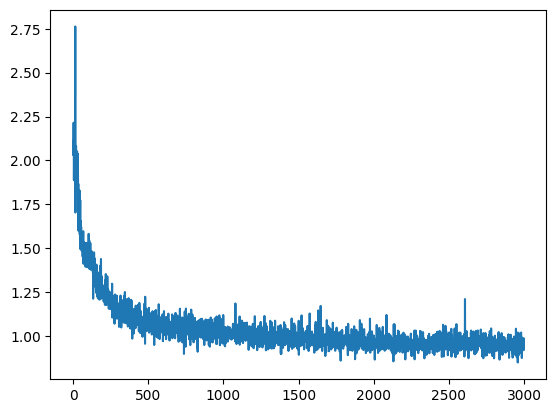

In [21]:
plt.plot(np.arange(len(genot.metrics["loss"])), genot.metrics["loss"])

In [22]:
res_train = [None] * 30
res_test = [None] * 30

for i in range(30):
    res_train[i] = genot.transport(source_train, seed=i)[0][0,...]
    res_test[i] = genot.transport(source_test, seed=i)[0][0,...]

In [23]:
cond_mean_train = jnp.mean(jnp.asarray(res_train), axis=0)
cond_mean_test = jnp.mean(jnp.asarray(res_test), axis=0)

In [24]:
foscttm(res_train[0], target_train)

0.515

In [25]:
foscttm(res_test[0], target_test)

0.5196

In [26]:
foscttm(cond_mean_train, target_train)

0.5232

In [27]:
foscttm(cond_mean_test, target_test)

0.5274

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


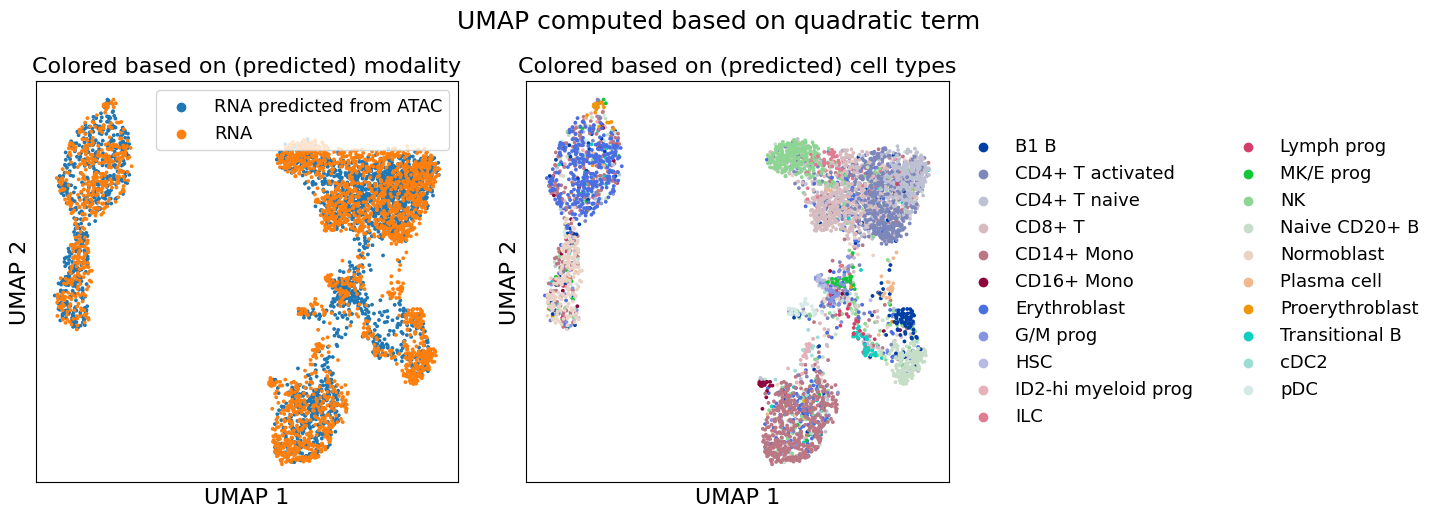

In [28]:
adata_one_sample = sc.concat(
    [adata_source_test, adata_target_test],
    join="outer",
    label="batch",
    keys=["RNA predicted from ATAC", "RNA"],
)
adata_one_sample.obsm["X_translated_0"] = np.concatenate(
    (res_test[0], target_test), axis=0
)
sc.pp.neighbors(adata_one_sample, use_rep="X_translated_0")
sc.tl.umap(adata_one_sample)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("UMAP computed based on quadratic term", size=18, y=0.9)
sc.pl.umap(adata_one_sample, color=["batch"], ax=ax1, show=False, size=30, legend_fontsize=10)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality", fontsize=16)
ax1.set_xlabel('UMAP 1', fontsize=16)
ax1.set_ylabel('UMAP 2', fontsize=16)
sc.pl.umap(adata_one_sample, color=["cell_type"], ax=ax2, show=False, size=30, legend_fontsize=13)
ax2.set_title("Colored based on (predicted) cell types", fontsize=16)
ax2.set_xlabel('UMAP 1', fontsize=16)
ax2.set_ylabel('UMAP 2', fontsize=16)
ax1.legend(fontsize=13)
plt.tight_layout(pad=3.0)
plt.show()

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


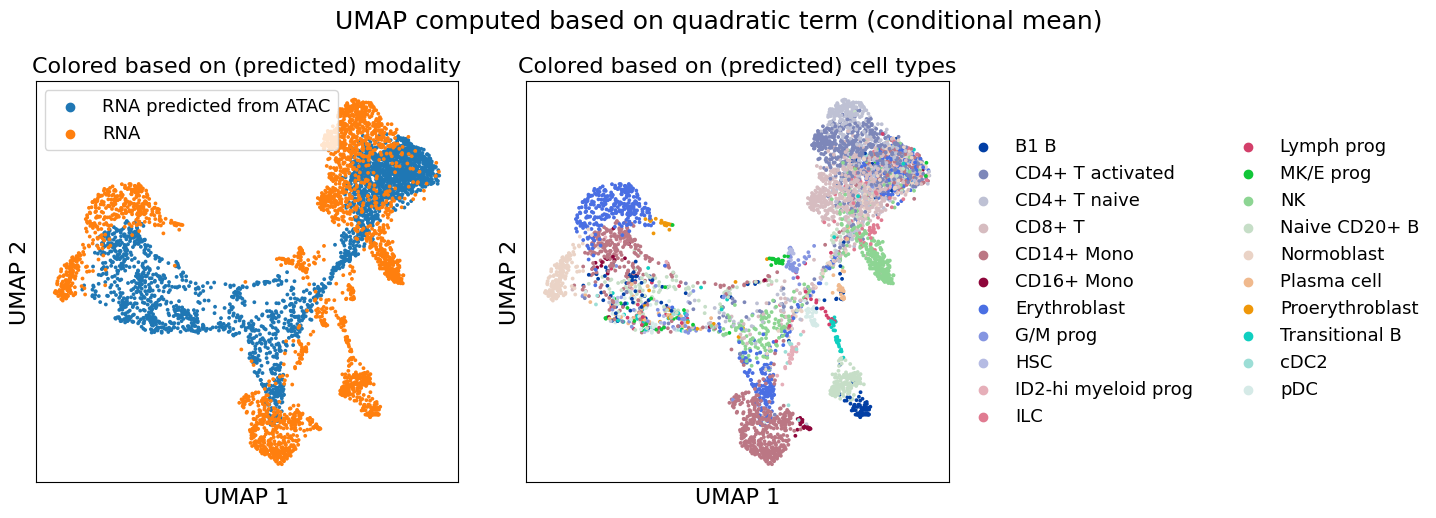

In [29]:
adata_cond_mean = sc.concat(
    [adata_source_test, adata_target_test],
    join="outer",
    label="batch",
    keys=["RNA predicted from ATAC", "RNA"],
)
adata_cond_mean.obsm["X_translated_0"] = np.concatenate(
    (cond_mean_test, target_test), axis=0
)
sc.pp.neighbors(adata_cond_mean, use_rep="X_translated_0")
sc.tl.umap(adata_cond_mean)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("UMAP computed based on quadratic term (conditional mean)", size=18, y=0.9)

sc.pl.umap(adata_cond_mean, color=["batch"], ax=ax1, show=False, size=30, legend_fontsize=10)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality", fontsize=16)
ax1.set_xlabel('UMAP 1', fontsize=16)
ax1.set_ylabel('UMAP 2', fontsize=16)
sc.pl.umap(adata_cond_mean, color=["cell_type"], ax=ax2, show=False, size=30, legend_fontsize=13)
ax2.set_title("Colored based on (predicted) cell types", fontsize=16)
ax2.set_xlabel('UMAP 1', fontsize=16)
ax2.set_ylabel('UMAP 2', fontsize=16)
ax1.legend(fontsize=13)
plt.tight_layout(pad=3.0)
plt.show()